# Survival *lifelines*
[https://lifelines.readthedocs.io/](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html)

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [21]:
df_files = pd.read_csv("datasets/cancers/lung/files.txt", sep="\t").dropna(how="all", thresh=300, axis=1)
df_files.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1145 entries, 0 to 1144
Data columns (total 13 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   cases.0.demographic.days_to_birth              1098 non-null   float64
 1   cases.0.demographic.days_to_death              456 non-null    float64
 2   cases.0.demographic.gender                     1145 non-null   object 
 3   cases.0.demographic.vital_status               1145 non-null   object 
 4   cases.0.diagnoses.0.age_at_diagnosis           1098 non-null   float64
 5   cases.0.diagnoses.0.days_to_last_follow_up     869 non-null    float64
 6   cases.0.diagnoses.0.last_known_disease_status  1145 non-null   object 
 7   cases.0.diagnoses.0.tumor_stage                1145 non-null   object 
 8   cases.0.exposures.0.cigarettes_per_day         867 non-null    float64
 9   cases.0.exposures.0.years_smoked               467 n

In [22]:
df_files["cases.0.diagnoses.0.last_known_disease_status"].unique()

array(['not reported'], dtype=object)

In [24]:
bins = np.linspace(0,100,20)
avg = df_files["cases.0.diagnoses.0.age_at_diagnosis"].mean()
df_files["age_at_diagnosis"]=pd.cut(df_files["cases.0.diagnoses.0.age_at_diagnosis"].fillna(avg)/365., bins=bins, labels = (bins[1:]+bins[:-1])/2).__array__()

In [25]:
df_files["gender"] = (df_files["cases.0.demographic.gender"]=="male").astype(int)

In [55]:
df_files["tumor_stage"]=df_files["cases.0.diagnoses.0.tumor_stage"]
for i,stage in enumerate(["stage i", "stage ii", "stage iii", "stage iv", "stage v"]):
    df_files["tumor_stage"].replace(stage, i+1, inplace=True)

In [58]:
for letter in ["a", "b"]:
    for (old, new) in zip(["stage %s%s"%(i,letter) for i in ["i", "ii", "iii", "iv"]],["stage %s"%i for i in ["i", "ii", "iii", "iv"]]):
        df_files.replace(old, new, inplace=True)
df_files["cases.0.diagnoses.0.tumor_stage"].unique()

array(['stage iii', 'stage i', 'stage ii', 'stage iv', 'not reported'],
      dtype=object)

In [28]:
#1 = Alive
df_files["vital_status"]=(df_files["cases.0.demographic.vital_status"]=="Dead").astype(int)

['not reported']


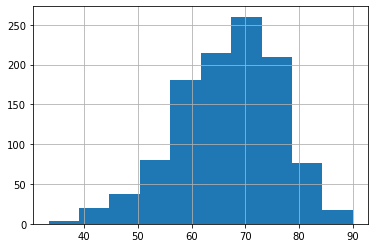

In [29]:
print(df_files["cases.0.diagnoses.0.last_known_disease_status"].unique())
(df_files["cases.0.diagnoses.0.age_at_diagnosis"]/365).hist()

In [189]:
def get_survival(case):
    if case["cases.0.demographic.vital_status"] == 1:
        return case["cases.0.demographic.days_to_death"]
    else:
        return case["cases.0.diagnoses.0.days_to_last_follow_up"]

df_files["days_survival"] = df_files.apply(get_survival,1)

In [190]:
bins = np.linspace(0,100,10)
df_files["smoke"] = pd.cut(df_files["cases.0.exposures.0.years_smoked"], bins=bins, labels = (bins[1:]+bins[:-1])/2 ).__array__()
df_files["smoke"].fillna(0, inplace=True)

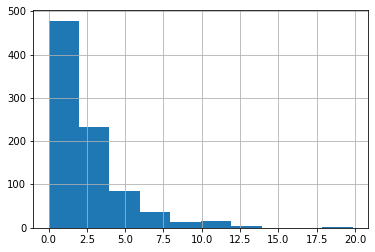

In [191]:
(df_files["days_survival"]/365).hist()

In [192]:
subset = df_files[~df_files["days_survival"].isna()].sample(80)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  app.launch_new_instance()


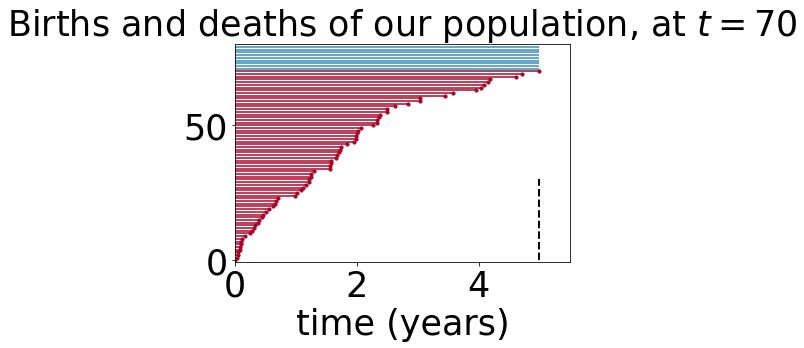

In [195]:
from lifelines.plotting import plot_lifetimes

CURRENT_TIME = 5

actual_lifetimes = subset["days_survival"].to_numpy()/365
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME

ax = plot_lifetimes(observed_lifetimes, event_observed=death_observed, figsize=(18,15))

ax.set_xlim(0, CURRENT_TIME*1.1)
ax.vlines(CURRENT_TIME, 0, 30, lw=2, linestyles='--')
ax.set_xlabel("time (years)", fontsize=35)
ax.tick_params(labelsize=35)
ax.set_title("Births and deaths of our population, at $t=70$", fontsize=35)
plt.tight_layout()
#print("Observed lifetimes at time %d:\n" % (CURRENT_TIME), observed_lifetimes)

In [197]:
subset = df_files[~df_files["days_survival"].isna()]
data = {}
data["duration"]=subset["days_survival"]/365
data["observed"]=subset["vital_status"]
data["entry"]=subset["cases.0.demographic.days_to_birth"]/365

In [198]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [199]:
df_files["vital_status"].sum()

465

In [200]:
T = data["duration"]
E = data["observed"]
entry = data["entry"]

kmf.fit(T, event_observed=E, entry = entry)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 869 total observations, 674 right-censored observations>

(0, 15)

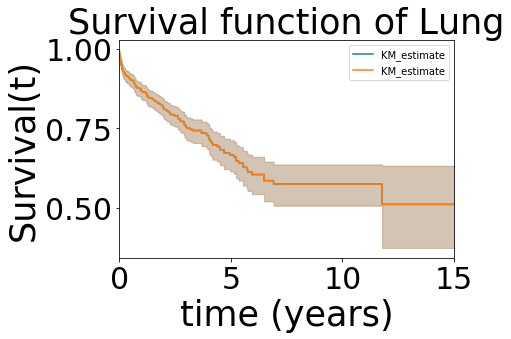

In [202]:
ax = kmf.plot()

kmf.fit(T, event_observed=E)
ax = kmf.plot(ax=ax)


ax.set_title('Survival function of Lung', fontsize=35)
ax.set_xlabel("time (years)", fontsize=35)
ax.set_ylabel("Survival(t)", fontsize=35)
ax.tick_params(labelsize=30)
ax.set_xlim(0,15)

In [203]:
from lifelines.utils import median_survival_times
median_ci = median_survival_times(kmf.confidence_interval_)
print(kmf.median_survival_time_, "+-", median_ci)

inf +-      KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5               11.778082                     inf


Text(0.5, 1.0, 'Survival of different cancer types')

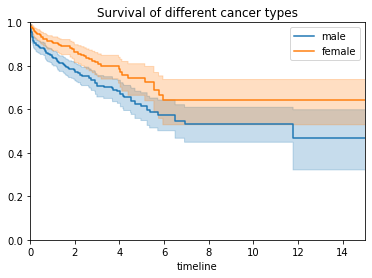

In [205]:
ax = plt.subplot(111)

mask = (subset["cases.0.demographic.gender"]=="male")

kmf.fit(T[mask], event_observed=E[mask], label="male")
kmf.plot(ax=ax)

kmf.fit(T[~mask], event_observed=E[~mask], label="female")
kmf.plot(ax=ax)

plt.ylim(0, 1)
plt.xlim(0,15)
plt.title("Survival of different cancer types")

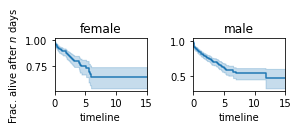

In [212]:
key = 'cases.0.demographic.gender'
labels = subset[key].unique()

for i, label in enumerate(np.sort(labels)):
    ax = plt.subplot(3, 3, i + 1)

    ix = subset[key] == label
    kmf.fit(T[ix], E[ix], label=label)
    kmf.plot(ax=ax, legend=False)

    plt.title(label)
    plt.xlim(0, 15)

    if i==0:
        plt.ylabel('Frac. alive after $n$ days')

plt.tight_layout()

In [213]:
from lifelines import CoxPHFitter

In [214]:
subset = df_files[(~df_files["days_survival"].isna()) & (df_files["cases.0.diagnoses.0.tumor_stage"]!="not reported")]
subset_index = subset["file_name"]
subset = subset[["days_survival","vital_status","gender", "tumor_stage", "age_at_diagnosis"]]

In [270]:
df_clusters = pd.read_csv("datasets/cancers/lung/topsbm/topsbm_level_1_topic-dist.csv",index_col=1).drop("i_doc",1)
topic = "Topic 10"
mask=df_clusters[topic]>df_clusters[topic].quantile(0.75)
up_samples = df_clusters[mask].index
subset["group"] = np.zeros(subset.shape[0])
subset.loc[subset_index.isin(up_samples),["group"]]=1
subset["group"]=subset["group"].astype(int)

In [271]:
cph = CoxPHFitter()
cph.fit(subset, duration_col='days_survival', event_col='vital_status')
cph.print_summary()

In [272]:
from statsmodels.stats.multitest import multipletests
multipletests(cph.summary["p"], method="bonferroni")[1]

array([1.64592385e-02, 4.47064532e-04, 1.34534206e-01, 1.00000000e+00])

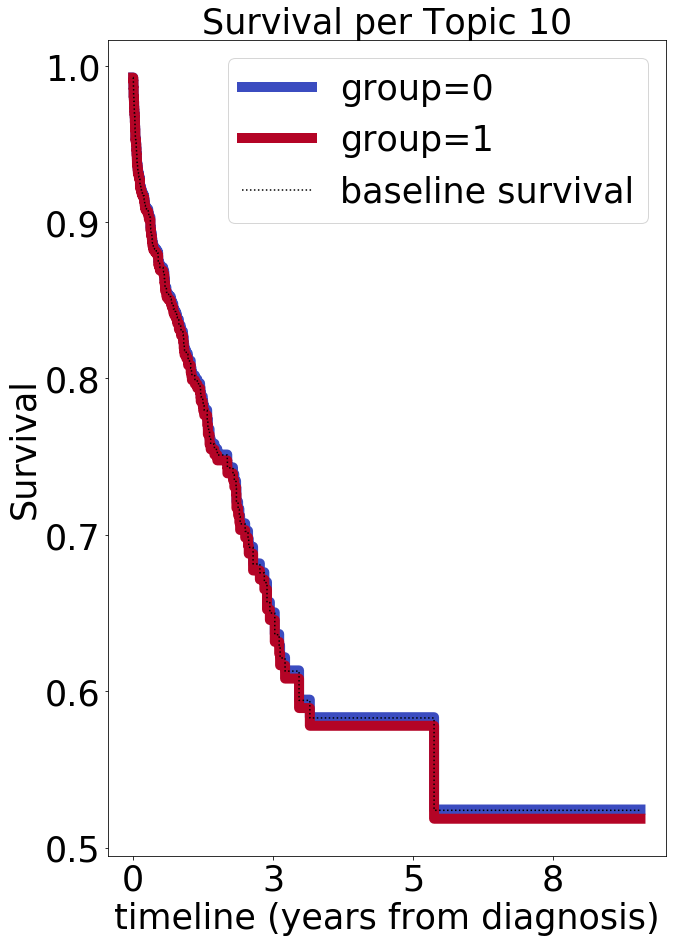

In [273]:
ax = cph.plot_covariate_groups('group', [0,1], cmap='coolwarm', lw=10, figsize=(10,15))
ax.set_title(f"Survival per {topic}", fontsize=35)
ax.set_xlabel("timeline (years from diagnosis)", fontsize=35)
ax.set_ylabel("Survival", fontsize=35)

lab = np.round(ax.get_xticks()/365).astype(int)
ax.set_xticklabels(lab)
ax.tick_params(labelsize=35)
ax.legend(fontsize=35)

In [252]:
for g in pd.read_csv("datasets/cancers/lung/topsbm/topsbm_level_1_topics.csv",index_col=1)["Topic 4"].values:
    print(g[:15])

ENSG00000124107
ENSG00000132465
ENSG00000211899
ENSG00000090382
ENSG00000126709
ENSG00000196154
ENSG00000135480
ENSG00000148346
ENSG00000187608
ENSG00000165949
ENSG00000116285
ENSG00000117472
ENSG00000005884
ENSG00000105854
ENSG00000105825
ENSG00000006327
ENSG00000047457
ENSG00000172724
ENSG00000160862
ENSG00000120306
ENSG00000123689
ENSG00000132821
ENSG00000181649
ENSG00000132329
ENSG00000173267
ENSG00000137965
ENSG00000101210
ENSG00000167772
ENSG00000089127
ENSG00000019102
ENSG00000139211
ENSG00000157601
ENSG00000162545
ENSG00000104267
ENSG00000135318
ENSG00000158825
ENSG00000166825
ENSG00000115828
ENSG00000104783
ENSG00000168140
ENSG00000023445
ENSG00000253368
ENSG00000151651
ENSG00000183508
ENSG00000156127
ENSG00000198517
ENSG00000185745
ENSG00000103485
ENSG00000117091
ENSG00000116661
ENSG00000139629
ENSG00000147454
ENSG00000131016
ENSG00000115255
ENSG00000145287
ENSG00000204839
ENSG00000175505
ENSG00000115226
ENSG00000164078
ENSG00000176920
ENSG00000243449
ENSG00000131037
ENSG0000

TypeError: 'float' object is not subscriptable

In [254]:
(pd.read_csv("datasets/cancers/lung/topsbm/topsbm_level_1_topics.csv",index_col=1)=="ENSG00000121552").any()

Topic 1     False
Topic 3     False
Topic 4     False
Topic 5     False
Topic 6     False
Topic 7     False
Topic 8     False
Topic 9     False
Topic 10    False
Topic 11    False
Topic 12    False
dtype: bool